In [1]:
import sys
import os
import math
import numpy as np
import matplotlib
import cv2
import skimage
import tensorflow as tf
print('tf: {}'.format(tf.__version__))

tf: 1.9.0


In [2]:
from tensorflow.keras import layers
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt


In [3]:
#define fumctions for image quality metrices

# Mean squared error(MSE)
def MSE(target, ref):
    
    error = np.sum((target.astype('float') - ref.astype('float')) **2)
    error /= float(target.shape[0] * target.shape[1])
    
    return error

#Peak-Signal-To-Noise-Ratio
def PSNR(target, ref):
    
    #assume RGB/BGR image
    target_data=target.astype(float)
    ref_data=ref.astype(float)
    
    diff=ref_data - target_data
    diff=diff.flatten('C')
    
    rmse=math.sqrt(np.mean(diff ** 2))
    
    return 20 * math.log10(255. / rmse)

#function to combine all three image quality metrices
def Compare_Images(target, ref):
    scores=[]
    scores.append(PSNR(target, ref))
    scores.append(MSE(target, ref))
    scores.append(ssim(target, ref, multichannel= True))
    
    return scores
    

In [4]:
#prepare degraded images by intruducing quality distortion
def Prepare_Images(path, factor):
    for file in os.listdir(path):
        
        img=cv2.imread(path + '/' + file )
        
        #old dimensions
        h,w,c=img.shape
        
        #new diemnsions
        new_height= int(h / factor)
        new_width= int(w / factor)
        
        #resize the images - down
        img = cv2.resize(img, (new_width, new_height), interpolation= cv2.INTER_LINEAR)
        
        #resize the images - up
        img = cv2.resize(img, (w,h), interpolation= cv2.INTER_LINEAR)
        
        #save the images
        print('Saving{}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)
        

In [5]:
Prepare_Images('source/', 2)

Savingbaboon.bmp
Savingbaby_GT.bmp
Savingbarbara.bmp
Savingbird_GT.bmp
Savingbutterfly_GT.bmp
Savingcoastguard.bmp
Savingcomic.bmp
Savingface.bmp
Savingflowers.bmp
Savingforeman.bmp
Savinghead_GT.bmp
Savinglenna.bmp
Savingmonarch.bmp
Savingpepper.bmp
Savingppt3.bmp
Savingwoman_GT.bmp
Savingzebra.bmp


In [6]:
#check the degraded image which are generated using quality metrices
for file in os.listdir('images/'):
    
    #read both target and ground_truth(reference) images
    target=cv2.imread('images/{}'.format(file))
    ref=cv2.imread('source/{}'.format(file))
    
    #calculate the scores
    scores=Compare_Images(target, ref)

    print("{}\nPSNR: {} \nMSE: {}\nSSIM: {}\n".format(file,scores[0],scores[1],scores[2]))


baboon.bmp
PSNR: 22.157084083442548 
MSE: 1187.1161333333334
SSIM: 0.629277587900277

baby_GT.bmp
PSNR: 34.37180640966199 
MSE: 71.28874588012695
SSIM: 0.9356987872724932

barbara.bmp
PSNR: 25.906629837568126 
MSE: 500.65508535879627
SSIM: 0.8098632646406401

bird_GT.bmp
PSNR: 32.896644728720005 
MSE: 100.12375819830247
SSIM: 0.9533644866026473

butterfly_GT.bmp
PSNR: 24.782076560337416 
MSE: 648.6254119873047
SSIM: 0.8791344763843051

coastguard.bmp
PSNR: 27.161600663887082 
MSE: 375.00887784090907
SSIM: 0.756950063354931

comic.bmp
PSNR: 23.799861502225532 
MSE: 813.2338836565096
SSIM: 0.8347335416398209

face.bmp
PSNR: 30.99220650287191 
MSE: 155.23189718546524
SSIM: 0.8008439492289884

flowers.bmp
PSNR: 27.454504805386147 
MSE: 350.55093922651935
SSIM: 0.8697286286974628

foreman.bmp
PSNR: 30.14456532664372 
MSE: 188.6883483270202
SSIM: 0.933268417388899

head_GT.bmp
PSNR: 31.020502848237534 
MSE: 154.2237755102041
SSIM: 0.8011121330733371

lenna.bmp
PSNR: 31.47349297867539 
MSE: 1

In [8]:
# SRCNN Model 
def model():
    
    SRCNN=tf.keras.models.Sequential()
    # add layers
    SRCNN.add(layers.Conv2D(filters=128, kernel_size=(9,9), kernel_initializer='glorot_uniform',activation='relu',
                     input_shape=(None,None,1), padding='valid', use_bias=True))
    SRCNN.add(layers.Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='glorot_uniform',activation='relu',
                     padding='same', use_bias=True))
    SRCNN.add(layers.Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform',activation='linear',
                     padding='valid', use_bias=True))
    
    #optimizer
    Adam=tf.keras.optimizers.Adam(lr=0.0003)
    
    SRCNN.compile(optimizer=Adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

In [9]:
# necessary image preprocessing functions
def ModCrop(img, scale):
    temp_size=img.shape
    size=temp_size[0:2]
    
    #ensuring that dimension of our images are divisble by certain scale by subtracting the remainder from dimensions
    size=size -np.mod(size, scale)
    
    #size[0] and size[1] respectively defines the dimensions after scaling and say the dimension after scaling  is 256 *256 px
    # so  img[0:256,1:256] gives us all pixel information
    
    img= img[0:size[0], 1:size[1]]
    
    return img

 
# function to crop an image
def Crop(image, border):
    img=image[border:-border, border:-border]
    return img
    

In [10]:
# Main prediction function

def predict(image_path):
    
    srcnn=model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    #load the degraded and refernce images
    path, file=os.path.split(image_path)
    degraded=cv2.imread(image_path)
    ref=cv2.imread('source/{}'.format(file))
    
    #preprocess the image or crop the image using modcrop
    degraded=ModCrop(degraded, 3)
    ref=ModCrop(ref,3)
    
    #convert the image to YCrCb as srcnn trained on Y channel
    temp=cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize
    Y=np.zeros((1,temp.shape[0],temp.shape[1],1), dtype=float)
    Y[0,:,:,0]=temp[:,:,0].astype(float) / 255
    
    # apply the model 
    pre=srcnn.predict(Y,batch_size=1)
    
    #post_process output
    pre *=255 #to get back the normal pixel values
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre=pre.astype(np.uint8)
    
    # copying y channel back to image and convert image to BGR
    temp=Crop(temp, 6) #by doing this the image will loose 3 pixels in both left and top and right-bottom
    temp[:, :, 0] = pre[0,:, :, 0]
    reconstructed_image=cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    #remove border from degraded and reference images
    degraded=Crop(degraded.astype(np.uint8), 6)
    ref=Crop(ref.astype(np.uint8), 6)
    
    #image quality calculations
    scores=[]
    scores.append(Compare_Images(degraded, ref))
    scores.append(Compare_Images(reconstructed_image, ref))
    
    #return images and scores
    return ref, degraded, reconstructed_image, scores
    
    

Degraded Image:
PSNR: 25.888852808173493 
MSE: 502.7086229899586
SSIM: 0.8086912237988951

Reconstructed Image:
PSNR: 26.575779039435897 
MSE: 429.1644221413023
SSIM: 0.8550465844171153



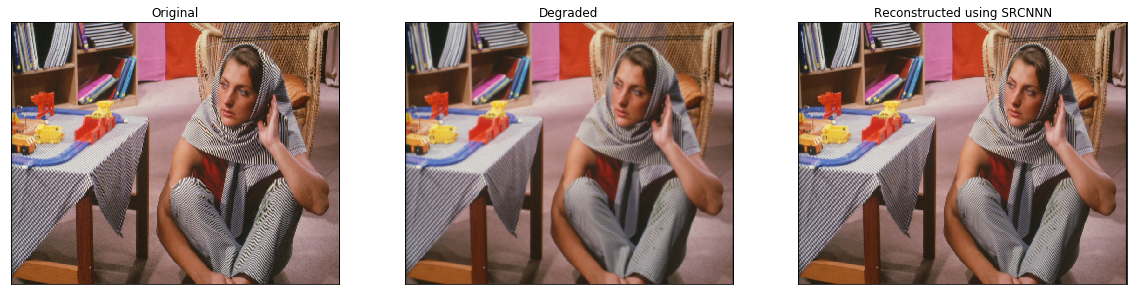

In [11]:
ref, degraded, reconstructed_image, scores= predict('images/barbara.bmp')
#print scores
print("Degraded Image:\nPSNR: {} \nMSE: {}\nSSIM: {}\n".format(scores[0][0],scores[0][1],scores[0][2]))
print("Reconstructed Image:\nPSNR: {} \nMSE: {}\nSSIM: {}\n".format(scores[1][0],scores[1][1],scores[1][2]))

#display images as subplot
fig, axes=plt.subplots(1,3, figsize=(20, 10))
axes[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)) #we convert the image from BGR to RGB as "imshow" wants the image as RGB format
axes[0].set_title('Original')
axes[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axes[1].set_title('Degraded')
axes[2].imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
axes[2].set_title('Reconstructed using SRCNNN')

#remove x and y axis tick marks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
